In [2]:
# -*- coding: utf-8 -*-
"""
Script to perform fixed number of GMM iterations on simple dataset
and write weights, means, covariances, and responsibilities to file.

Modified to read in sample of SDSS/2MASS photometry.


SQL Query that generated this dataset (limited to 500,000 rows):

select s.psfmag_g as g, s.psfmag_r as r, s.psfmag_i as i, w.j_m_2mass as J, w.h_m_2mass as H, w.k_m_2mass as K,
w.w1mpro as w1, w.w2mpro as w2, w.w3mpro as w3, w.w4mpro as w4, s.type as class
from wise_xmatch as xm join photoPrimary as s on xm.sdss_objid = s.objid join wise_allsky as w on xm.wise_cntr = w.cntr
where w.j_m_2mass <> 9999 and w.h_m_2mass <> 9999 and w.k_m_2mass <> 9999 and s.psfmag_g <> -9999 and s.psfmag_r <> -9999
and s.psfmag_i <> -9999
"""

import numpy as np
from sklearn.mixture import GMM
import time
import pyfits
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('xtick', labelsize=16)     
mpl.rc('ytick', labelsize=16)  
mpl.rc('axes', labelsize=20)
mpl.rc('legend', fontsize=20)
mpl.rc('lines', linewidth=2)
mpl.rc('font', size=18, family='serif', style='normal', variant='normal', stretch='normal', weight='normal')
%matplotlib inline


from xdeconv_testing import XDGMM
from astroML.crossmatch import crossmatch
from astroML.datasets import fetch_sdss_S82standards, fetch_imaging_sample
from astroML.plotting.tools import draw_ellipse
from astroML.decorators import pickle_results
from astroML.stats import sigmaG



### Read and inspect data

In [2]:
#rawData = np.genfromtxt('r1718_errorcut.csv', delimiter=',', names=['objid', 'sdssra', 'sdssdec', 'type', 'flags', 'cmodelmag_u', 'cmodelmag_g', 'cmodelmag_r', 'cmodelmag_i', 'cmodelmag_z', 'cmodelmagerr_u', 'cmodelmagerr_g', 'cmodelmagerr_r', 'cmodelmagerr_i', 'cmodelmagerr_z', 'psfmag_u', 'psfmag_g', 'psfmag_r', 'psfmag_i', 'psfmag_z', 'psfmagerr_u', 'psfmagerr_g', 'psfmagerr_r', 'psfmagerr_i', 'psfmagerr_z', 'cntr', 'wisera', 'wisedec', 'w1mag', 'w1sigmag', 'w2mag', 'w2sigmag', 'w3mag', 'w3sigmag', 'w4mag', 'w4sigmag', 'j_m_2mass', 'j_msig_2mass', 'h_m_2mass', 'h_msig_2mass', 'k_m_2mass', 'k_msig_2mass'])
rawData = np.genfromtxt('wise_alltypes_r17_200k.csv', delimiter=',', names=['objid', 'sdssra', 'sdssdec', 'type', 'flags', 'cmodelmag_u', 'cmodelmag_g', 'cmodelmag_r', 'cmodelmag_i', 'cmodelmag_z', 'cmodelmagerr_u', 'cmodelmagerr_g', 'cmodelmagerr_r', 'cmodelmagerr_i', 'cmodelmagerr_z', 'psfmag_u', 'psfmag_g', 'psfmag_r', 'psfmag_i', 'psfmag_z', 'psfmagerr_u', 'psfmagerr_g', 'psfmagerr_r', 'psfmagerr_i', 'psfmagerr_z', 'cntr', 'wisera', 'wisedec', 'w1mag', 'w1sigmag', 'w2mag', 'w2sigmag', 'w3mag', 'w3sigmag', 'w4mag', 'w4sigmag', 'j_m_2mass', 'j_msig_2mass', 'h_m_2mass', 'h_msig_2mass', 'k_m_2mass', 'k_msig_2mass'])

#wise_alltypes_r17.csv
#dataSkyServer = np.genfromtxt('data_sdss_2mass_wise.txt', delimiter=',', names=['g', 'r', 'i', 'J', 'H', 'K', \
#                                                                          'w1', 'w2', 'w3', 'w4', 'class'])


In [1]:
rawData.shape

NameError: name 'rawData' is not defined

In [4]:
"""
Create array of 4 colors (SDSS/WISE mags); exclude galaxies
"""
N_all = np.shape(rawData)[0]
colors = np.zeros((N_all, 4))

colors[:,0] = rawData['psfmag_g'] - rawData['psfmag_i']
colors[:,1] = rawData['psfmag_i'] - rawData['w1mag']
colors[:,2] = rawData['w2mag'] - rawData['w3mag']
colors[:,3] = rawData['w1mag'] - rawData['w2mag']



dumb_mask = rawData['w1mag'] != 9999 # only one row with this value... ugh
colors = colors[dumb_mask]

r_all = rawData['psfmag_r'][dumb_mask]


"""
Magnitude mask
"""

#all_mask = (r_all < 20) * (r_all > 16)

"""
Generate the all_colors array on which GMM will be run.
"""
# SDSS sample + quasar catalog, no mag cuts
#all_colors = np.concatenate((colors, colorsQSO), axis=0)

# SDSS sample + quasar catalog, with mag cuts
#all_colors_cut = np.concatenate((colors[all_mask], colorsQSO[QSO_mask]),axis=0)

# Try a different method of generating color color stuff

mags = np.zeros((N_all, 5))

mags[:,0] = rawData['psfmag_g']
mags[:,1] = rawData['psfmag_i']
mags[:,2] = rawData['w1mag']
mags[:,3] = rawData['w2mag']
mags[:,4] = rawData['w3mag']


errors = np.zeros((N_all, 5))

errors[:,0] = rawData['psfmagerr_g']
errors[:,1] = rawData['psfmagerr_i']
errors[:,2] = rawData['w1sigmag']
errors[:,3] = rawData['w2sigmag']
errors[:,4] = rawData['w3sigmag']


# Define the mixing matrix
W = np.array([[1, -1, 0, 0, 0],   # g-i color
              [0, 1, -1, 0, 0],   # i-w1 color
              [0, 0, 0, 1, -1],   # w2-w3 color
              [0, 0, 1, -1, 0]])  # w1-w2 color

X = np.dot(mags, W.T)

# compute error covariance from mixing matrix
Xcov = np.zeros(errors.shape + errors.shape[-1:])
Xcov[:, range(errors.shape[1]), range(errors.shape[1])] = errors ** 2

# each covariance C = WCW^T
# best way to do this is with a tensor dot-product
Xcov = np.tensordot(np.dot(Xcov, W.T), W, (-2, -1))


#all_colors = colors
all_colors = X

In [5]:
print X[0]

[ 0.7434  5.0602  2.32    0.841 ]


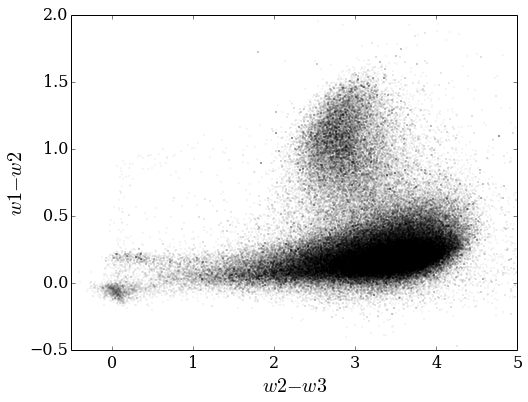

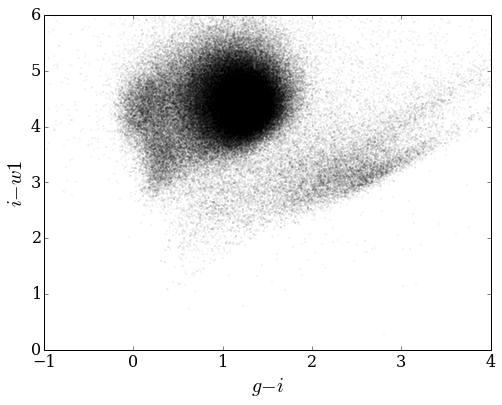

In [6]:
# plot up data - color QSOs differently to make clusters obvious

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(colors[:,2], colors[:,3], 'k.', ms=0.2)
ax.set_xlim([-0.5,5])
ax.set_ylim([-0.5,2])
ax.set_xlabel(r'$w2-w3$')
ax.set_ylabel(r'$w1-w2$')

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(colors[:,0], colors[:,1], 'k.', ms=0.2)
ax.set_xlim([-1,4])
ax.set_ylim([0,6])
ax.set_xlabel(r'$g-i$')
ax.set_ylabel(r'$i-w1$')

Quasars are still not very common in our SDSS sample (with magnitude cuts), but at least they form a discernible cluster without the requirement of 2MASS detection.

In [7]:
"""
Try GMM with 4 dimensions and 7 components
"""
gmm = GMM(n_components=7, n_init=1, random_state=10, covariance_type='full', min_covar=1.e-14)
gmm.fit(all_colors)
#responsibilities = gmm.predict_proba(bigcolors)
#resp = responsibilities
#weights = gmm.weights_
#means = gmm.means_
#cov = gmm.covars_
clusters = gmm.predict(all_colors)
gmm_clusters = np.array(clusters)

In [8]:
gmm_clusters = np.array(clusters)

In [9]:
weights = np.array(gmm.weights_)
means = np.array(gmm.means_)
cov = np.array(gmm.covars_)
print weights
gmm_vars = (weights, means, cov)

[ 0.08067954  0.16775217  0.06907008  0.25547613  0.01337056  0.10729505
  0.30635647]


### Fitted parameters in gmm_vars object

In [11]:
print gmm_vars

(array([ 0.08067954,  0.16775217,  0.06907008,  0.25547613,  0.01337056,
        0.10729505,  0.30635647]), array([[ 0.27394359,  4.09748244,  2.83417037,  1.10080655],
       [ 1.3132699 ,  4.47060175,  2.60344093,  0.12738451],
       [ 2.35483969,  3.34775638,  2.59068543,  0.10911761],
       [ 1.26391119,  4.30842719,  3.3062319 ,  0.30104834],
       [ 1.57419324,  5.94669236,  0.60162027,  0.05504618],
       [ 1.02635801,  4.25278659,  3.17482788,  0.60624899],
       [ 0.98604955,  4.64636282,  3.61452044,  0.18106949]]), array([[[  4.58464676e-02,  -1.61004008e-02,   1.52800199e-02,
           3.97108977e-03],
        [ -1.61004008e-02,   3.30276542e-01,  -7.57201989e-02,
          -6.00736973e-02],
        [  1.52800199e-02,  -7.57201989e-02,   7.23513374e-02,
           1.47541630e-02],
        [  3.97108977e-03,  -6.00736973e-02,   1.47541630e-02,
           3.73287592e-02]],

       [[  3.02171991e-02,   5.78808967e-03,  -2.26190071e-02,
           4.62540623e-03],
      

In [12]:
gmm_clusters = np.array(clusters)

### Run XD after initializing with GMM variables

In [13]:
n_clusters = 7
n_iter = 1

#----------------------------------------------------------------------
# This is a long calculation: save results to file
#@pickle_results("XD_stellar.pkl")
def compute_XD(n_clusters=7, rseed=0, n_iter=n_iter, verbose=True, gmm_vars=None):
    if gmm_vars is None:
        print "no gmm_initialization variables passed"
    np.random.seed(rseed)
    clf = XDGMM(n_clusters, n_iter=n_iter, tol=1E-5, verbose=verbose)
    clf.fit(X, Xcov, gmm_vars=gmm_vars)
    return clf

clf = compute_XD(n_clusters, gmm_vars=gmm_vars)

#------------------------------------------------------------
# Fit and sample from the underlying distribution
np.random.seed(10)
X_sample = clf.sample(X.shape[0])

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
(200000, 7)
10000 0.0784353017807
20000 0.283963517348
30000 0.485617518425
40000 0.658276514212
50000 0.871804833412
60000 1.0572341164
70000 1.24087206523
80000 1.35878886779
90000 1.55337728262
100000 1.75173183282
110000 1.95790325006
120000 2.09960623582
130000 2.26507786512
140000 2.61882563035
150000 2.5935270826
160000 31.4093169649
170000 3.00442459981
180000 3.16468233267
190000 3.35791831414
1: log(L) = -11108
    (1.4e+02 sec)
[[ 0.27482293  4.09691238  2.84025786  1.10116777]
 [ 1.31549451  4.46981176  2.61247872  0.12923343]
 [ 2.35304899  3.34459078  2.59355105  0.11427954]
 [ 1.26718154  4.30541996  3.31468847  0.30000917]
 [ 1.57657524  5.9698154   0.59675164  0.05447787]
 [ 1.03652921  4.25747615  3.17265922  0.62728334]
 [ 0.98403903  4.63819442  3.61768981  0.1845711 ]]

In [15]:
clf.alpha

array([ 0.08158497,  0.17005829,  0.06928557,  0.25023431,  0.0131725 ,
        0.09821617,  0.3174482 ])

In [14]:
xd_clusters = clf.logprob_a(X, Xcov)

In [40]:
gmm_clusters.shape

(200000,)

In [31]:
gmm_clusters[0]

5

In [33]:
xd_clusters[0]

array([  -4.74649301, -153.60018407,  -58.98270692,  -40.24733704,
        -11.19680247,   -2.91882699, -141.29487691])

In [39]:
np.argmax(xd_clusters, axis=1)

(200000,)

In [49]:
clusters = np.argmax(xd_clusters, axis=1)
#clusters = np.array(gmm_clusters)

### Show hard cluster assignments

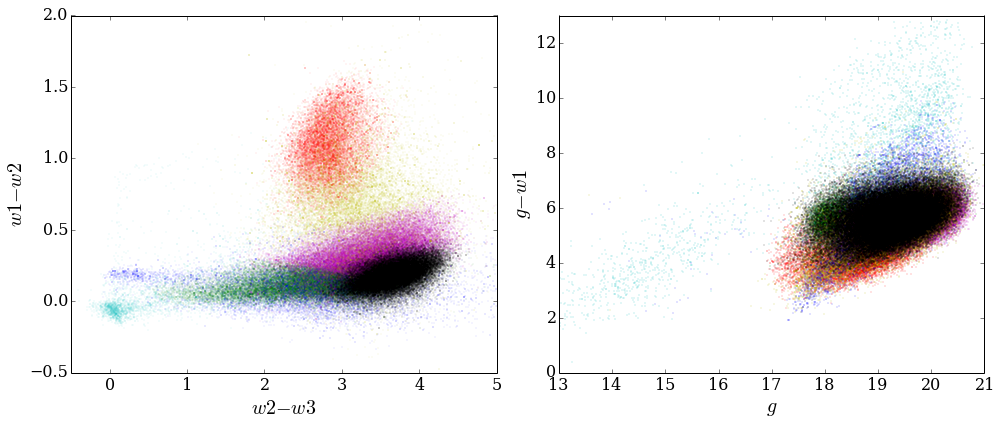

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))

ax[0].plot(all_colors[clusters == 0,2], all_colors[clusters == 0,3], 'r.', ms=0.2)
ax[0].plot(all_colors[clusters == 1,2], all_colors[clusters == 1,3], 'g.', ms=0.2)
ax[0].plot(all_colors[clusters == 2,2], all_colors[clusters == 2,3], 'b.', ms=0.2)
ax[0].plot(all_colors[clusters == 3,2], all_colors[clusters == 3,3], 'm.', ms=0.2)
ax[0].plot(all_colors[clusters == 4,2], all_colors[clusters == 4,3], 'c.', ms=0.2)
ax[0].plot(all_colors[clusters == 5,2], all_colors[clusters == 5,3], 'y.', ms=0.2)
ax[0].plot(all_colors[clusters == 6,2], all_colors[clusters == 6,3], 'k.', ms=0.2)
ax[0].set_xlim([-0.5,5])
ax[0].set_ylim([-0.5,2])
ax[0].set_xlabel(r'$w2-w3$')
ax[0].set_ylabel(r'$w1-w2$')

ax[1].plot((rawData['psfmag_g'])[clusters == 0], (rawData['psfmag_g'] - rawData['w1mag'])[clusters == 0], 'r.', ms=0.5)
ax[1].plot((rawData['psfmag_g'])[clusters == 1], (rawData['psfmag_g'] - rawData['w1mag'])[clusters == 1], 'g.', ms=0.5)
ax[1].plot((rawData['psfmag_g'])[clusters == 2], (rawData['psfmag_g'] - rawData['w1mag'])[clusters == 2], 'b.', ms=0.5)
ax[1].plot((rawData['psfmag_g'])[clusters == 3], (rawData['psfmag_g'] - rawData['w1mag'])[clusters == 3], 'm.', ms=0.5)
ax[1].plot((rawData['psfmag_g'])[clusters == 4], (rawData['psfmag_g'] - rawData['w1mag'])[clusters == 4], 'c.', ms=0.5)
ax[1].plot((rawData['psfmag_g'])[clusters == 5], (rawData['psfmag_g'] - rawData['w1mag'])[clusters == 5], 'y.', ms=0.5)
ax[1].plot((rawData['psfmag_g'])[clusters == 6], (rawData['psfmag_g'] - rawData['w1mag'])[clusters == 6], 'k.', ms=0.5)

ax[1].set_xlim([13,21])
ax[1].set_ylim([0,13])
ax[1].set_xlabel(r'$g$')
ax[1].set_ylabel(r'$g-w1$')

plt.tight_layout()

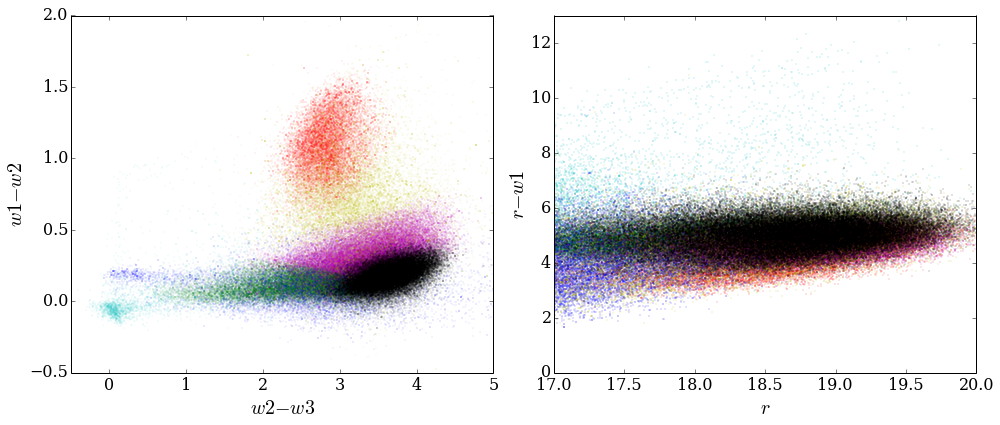

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))

ax[0].plot(all_colors[clusters == 0,2], all_colors[clusters == 0,3], 'r.', ms=0.2)
ax[0].plot(all_colors[clusters == 1,2], all_colors[clusters == 1,3], 'g.', ms=0.2)
ax[0].plot(all_colors[clusters == 2,2], all_colors[clusters == 2,3], 'b.', ms=0.2)
ax[0].plot(all_colors[clusters == 3,2], all_colors[clusters == 3,3], 'm.', ms=0.2)
ax[0].plot(all_colors[clusters == 4,2], all_colors[clusters == 4,3], 'c.', ms=0.2)
ax[0].plot(all_colors[clusters == 5,2], all_colors[clusters == 5,3], 'y.', ms=0.2)
ax[0].plot(all_colors[clusters == 6,2], all_colors[clusters == 6,3], 'k.', ms=0.2)
ax[0].set_xlim([-0.5,5])
ax[0].set_ylim([-0.5,2])
ax[0].set_xlabel(r'$w2-w3$')
ax[0].set_ylabel(r'$w1-w2$')

ax[1].plot((rawData['psfmag_r'])[clusters == 0], (rawData['psfmag_r'] - rawData['w1mag'])[clusters == 0], 'r.', ms=0.5)
ax[1].plot((rawData['psfmag_r'])[clusters == 1], (rawData['psfmag_r'] - rawData['w1mag'])[clusters == 1], 'g.', ms=0.5)
ax[1].plot((rawData['psfmag_r'])[clusters == 2], (rawData['psfmag_r'] - rawData['w1mag'])[clusters == 2], 'b.', ms=0.5)
ax[1].plot((rawData['psfmag_r'])[clusters == 3], (rawData['psfmag_r'] - rawData['w1mag'])[clusters == 3], 'm.', ms=0.5)
ax[1].plot((rawData['psfmag_r'])[clusters == 4], (rawData['psfmag_r'] - rawData['w1mag'])[clusters == 4], 'c.', ms=0.5)
ax[1].plot((rawData['psfmag_r'])[clusters == 5], (rawData['psfmag_r'] - rawData['w1mag'])[clusters == 5], 'y.', ms=0.5)
ax[1].plot((rawData['psfmag_r'])[clusters == 6], (rawData['psfmag_r'] - rawData['w1mag'])[clusters == 6], 'k.', ms=0.5)

ax[1].set_xlim([17,20])
ax[1].set_ylim([0,13])
ax[1].set_xlabel(r'$r$')
ax[1].set_ylabel(r'$r-w1$')

plt.tight_layout()

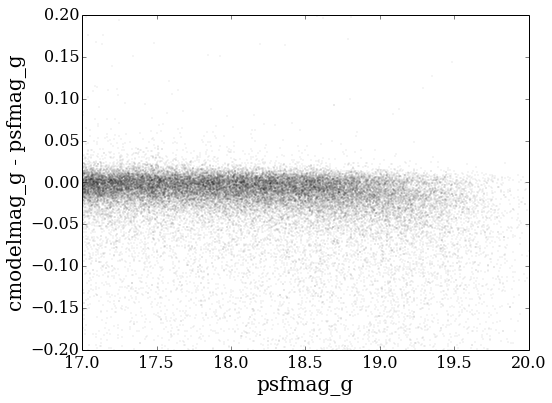

In [52]:
# plot up masked data (magnitude cuts) - only SDSS sample, none from quasar catalog

fig, ax = plt.subplots(figsize=(8,6))
#ax.plot((dataSkyServer['g']), (dataSkyServer['g'] - dataSkyServer['w1']), 'k.', ms=0.1)
ax.plot((rawData['psfmag_r']), (rawData['cmodelmag_r'] - rawData['psfmag_r']), 'k.', ms=0.2)
#ax.plot((rawData['psfmag_g'])[clusters == 1], (rawData['psfmag_g'] - rawData['w1mag'])[clusters == 1], 'g.', ms=0.5)
#ax.plot((rawData['psfmag_g'])[clusters == 2], (rawData['psfmag_g'] - rawData['w1mag'])[clusters == 2], 'b.', ms=0.5)
#ax.plot((rawData['psfmag_g'])[clusters == 3], (rawData['psfmag_g'] - rawData['w1mag'])[clusters == 3], 'm.', ms=0.5)
#ax.plot((rawData['psfmag_g'])[clusters == 4], (rawData['psfmag_g'] - rawData['w1mag'])[clusters == 4], 'c.', ms=0.5)
#ax.plot((rawData['psfmag_g'])[clusters == 5], (rawData['psfmag_g'] - rawData['w1mag'])[clusters == 5], 'y.', ms=0.5)
#ax.plot((rawData['psfmag_g'])[clusters == 6], (rawData['psfmag_g'] - rawData['w1mag'])[clusters == 6], 'k.', ms=0.5)
#x.plot(colorsQSO[:,2], colorsQSO[:,3], 'r.', ms=0.2)
ax.set_xlim([17,20])
ax.set_ylim([-.2,.2])
ax.set_xlabel(r'psfmag_g')
ax.set_ylabel(r'cmodelmag_g - psfmag_g')

#fig, ax = plt.subplots(figsize=(8,6))
#ax.plot(rawData['psfmag_r'], rawData['psfmag_r'] - rawData['w1mag'], 'k.', ms=0.2)
#ax.plot(colorsQSO[:,0], colorsQSO[:,1], 'r.', ms=0.2)
#ax.set_xlim([-1,4])
#ax.set_ylim([0,6])
#ax.set_xlabel(r'$g-i$')
#ax.set_ylabel(r'$i-w1$')

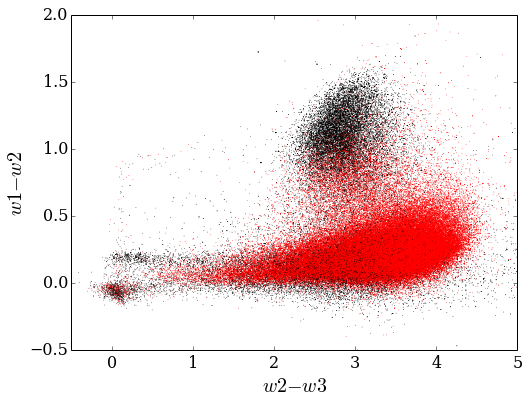

In [53]:
fig, ax = plt.subplots(figsize=(8,6))
colors_labels = ['red','green','blue','purple','yellow','blue','orange','black']
ax.scatter((rawData['w2mag'] - rawData['w3mag']), (rawData['w1mag']-rawData['w2mag']), c=rawData['type'], 
               cmap=mpl.colors.ListedColormap(colors_labels), lw = 0, s = .5)
ax.set_xlim([-0.5,5])
ax.set_ylim([-0.5,2])
ax.set_xlabel(r'$w2-w3$')
ax.set_ylabel(r'$w1-w2$')


In [54]:
print "GMM clusters"
clusters = np.array(gmm_clusters)
print "cid, n_points, galaxies,         point sources"
for i in range(7):
    cluster_size = rawData[clusters == i].shape[0]
    print (i, cluster_size, float(rawData[rawData[clusters == i]['type'] == 3.].shape[0])/cluster_size, 
        float(rawData[rawData[clusters == i]['type'] == 6.].shape[0])/cluster_size)
    
print ""
print ""
print "XD clusters"
clusters = np.argmax(xd_clusters, axis=1)
print "cid, n_points, galaxies,         point sources"
for i in range(7):
    cluster_size = rawData[clusters == i].shape[0]
    print (i, cluster_size, float(rawData[rawData[clusters == i]['type'] == 3.].shape[0])/cluster_size, 
        float(rawData[rawData[clusters == i]['type'] == 6.].shape[0])/cluster_size)


GMM clusters
cid, n_points, galaxies,         point sources
(0, 16595, 0.0963543235914432, 0.9036456764085568)
(1, 32022, 0.9915995253263381, 0.008400474673661857)
(2, 14223, 0.10384588342825002, 0.89615411657175)
(3, 48051, 0.9889700526523901, 0.011029947347609832)
(4, 2484, 0.322463768115942, 0.677536231884058)
(5, 17119, 0.6964191833635143, 0.3035808166364858)
(6, 69506, 0.9949788507466981, 0.005021149253301873)


XD clusters
cid, n_points, galaxies,         point sources
(0, 16858, 0.10054573496262902, 0.899454265037371)
(1, 40680, 0.9926991150442478, 0.007300884955752212)
(2, 14325, 0.1081326352530541, 0.891867364746946)
(3, 42901, 0.9922612526514534, 0.007738747348546654)
(4, 3422, 0.37726475745178256, 0.6227352425482174)
(5, 18379, 0.7374721149137603, 0.26252788508623975)
(6, 63435, 0.9961220146606763, 0.003877985339323717)


In [63]:
def card_true(boolvec):
    # Returns an interger cardinality of how many values are true 
    return boolvec[boolvec].shape[0]

In [64]:
def print_prec_recall(class_value, Ypred, Y_test):
    B = Ypred == class_value  # The instances we predict as true
    A = Y_test == class_value  # The instances that are actually true
    AandB = A & B
    if (card_true(B) > 0):
        precision = float(card_true(AandB))/card_true(B)
    else:
        precision = 0.
    if (card_true(A) > 0):
        recall = float(card_true(AandB))/card_true(A)
    else:
        recall = 0.
    print "For class", str(class_value),":    precision =", precision, ";   recall =", recall

In [105]:
gmm_predicted = np.array(gmm_clusters)
galaxy_mask = (gmm_clusters == 1) | (gmm_clusters == 3) | (gmm_clusters == 5) | (gmm_clusters == 6)
gmm_predicted[galaxy_mask] = 3
gmm_predicted[~galaxy_mask] = 6

In [106]:
float(gmm_predicted[(gmm_predicted == rawData['type'])].shape[0]) / gmm_predicted.shape[0]

0.94889

For GMM
Galaxy precision recall
For class 3.0 :    precision = 0.961937155815 ;   recall = 0.976392863667
Point source precision recall
For class 6.0 :    precision = 0.883580565732 ;   recall = 0.82261671792


In [77]:
xd_predicted = np.array(gmm_clusters)
xd_map_estimate = np.argmax(xd_clusters, axis=1)
galaxy_mask = (xd_map_estimate == 1) | (xd_map_estimate == 3) | (xd_map_estimate == 5) | (xd_map_estimate == 6)
xd_predicted[galaxy_mask] = 3
xd_predicted[~galaxy_mask] = 6

In [59]:
print "For GMM"
print "Galaxy precision recall"
print_prec_recall(3.0, gmm_predicted.astype(float), rawData['type'])
print "Point source precision recall"
print_prec_recall(6.0, gmm_predicted.astype(float), rawData['type'])

print ""

print "For XD"
print "Galaxy precision recall"
print_prec_recall(3.0, xd_predicted.astype(float), rawData['type'])
print "Point source precision recall"
print_prec_recall(6.0, xd_predicted.astype(float), rawData['type'])

For GMM
Galaxy precision recall


NameError: name 'print_prec_recall' is not defined

In [79]:
float(xd_predicted[(xd_predicted == rawData['type'])].shape[0]) / xd_predicted.shape[0]

0.948825

In [55]:
print "XD", 16858 *0.899454265037371 
print "GMM", 16595 *0.9036456764085568 

XD 15163.0
GMM 14996.0


In [17]:
cluster_size = float(rawData[clusters == 0].shape[0])
print (float(rawData[rawData[clusters == 0]['type'] == 3.].shape[0])/cluster_size, 
    float(rawData[rawData[clusters == 0]['type'] == 6.].shape[0])/cluster_size)

(0.0963543235914432, 0.9036456764085568)


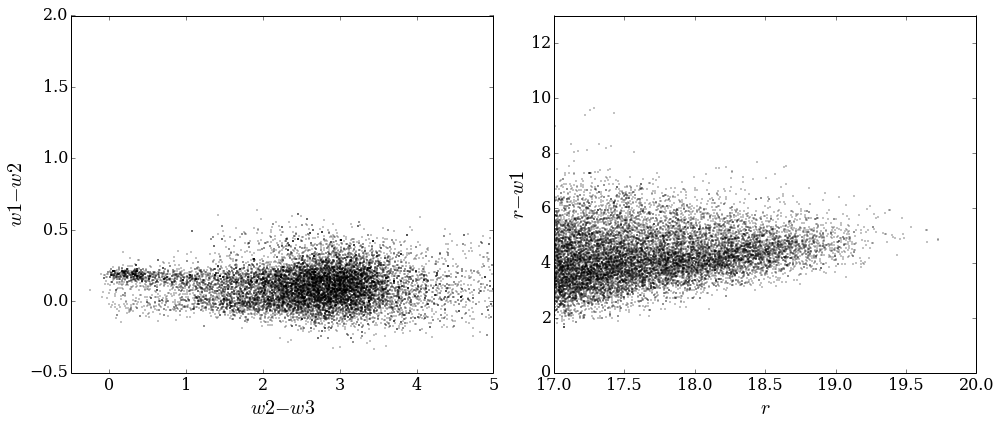

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))

ax[0].plot(all_colors[clusters == 2,2], all_colors[clusters == 2,3], 'k.', ms=1)
ax[0].set_xlim([-0.5,5])
ax[0].set_ylim([-0.5,2])
ax[0].set_xlabel(r'$w2-w3$')
ax[0].set_ylabel(r'$w1-w2$')

ax[1].plot((rawData['psfmag_r'])[clusters == 2], (rawData['psfmag_r'] - rawData['w1mag'])[clusters == 2], 'k.', ms=1)

ax[1].set_xlim([17,20])
ax[1].set_ylim([0,13])
ax[1].set_xlabel(r'$r$')
ax[1].set_ylabel(r'$r-w1$')

plt.tight_layout()

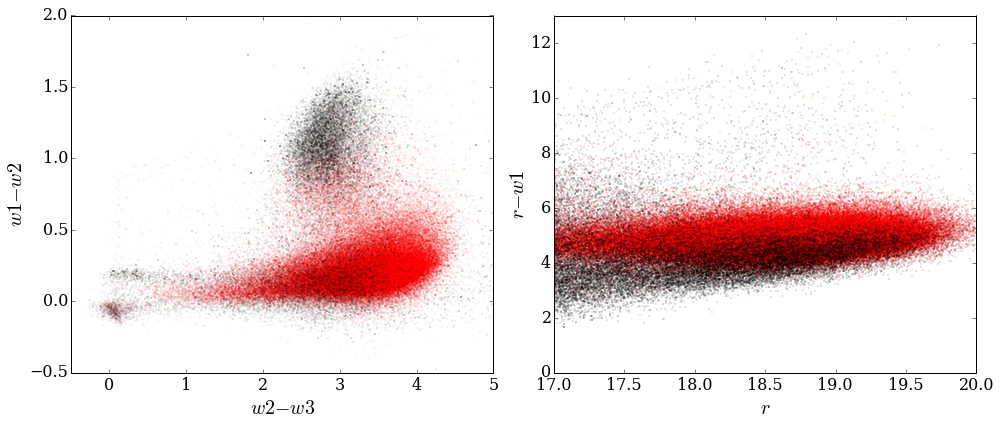

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))

ax[0].plot(all_colors[rawData['type']==3.,2], all_colors[rawData['type']==3,3], 'r.', ms=0.2)
ax[0].plot(all_colors[rawData['type']==6.,2], all_colors[rawData['type']==6,3], 'k.', ms=0.2)
ax[0].set_xlim([-0.5,5])
ax[0].set_ylim([-0.5,2])
ax[0].set_xlabel(r'$w2-w3$')
ax[0].set_ylabel(r'$w1-w2$')

ax[1].plot((rawData['psfmag_r'])[rawData['type']==3.], (rawData['psfmag_r'] - rawData['w1mag'])[rawData['type']==3.], 'r.', ms=0.5)
ax[1].plot((rawData['psfmag_r'])[rawData['type']==6.], (rawData['psfmag_r'] - rawData['w1mag'])[rawData['type']==6.], 'k.', ms=0.5)

ax[1].set_xlim([17,20])
ax[1].set_ylim([0,13])
ax[1].set_xlabel(r'$r$')
ax[1].set_ylabel(r'$r-w1$')

plt.tight_layout()

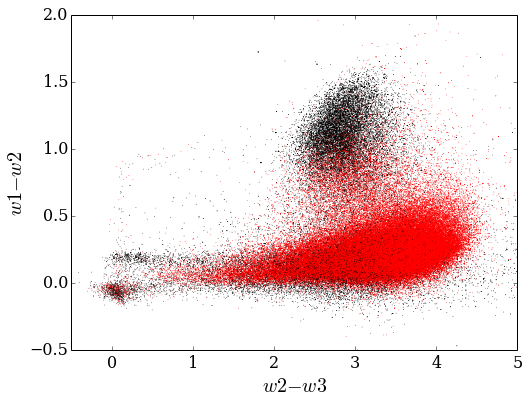

In [18]:
fig, ax = plt.subplots(figsize=(8,6))
colors_labels = ['red','green','blue','purple','yellow','blue','orange','black']
ax.scatter((rawData['w2mag'] - rawData['w3mag']), (rawData['w1mag']-rawData['w2mag']), c=rawData['type'], 
               cmap=mpl.colors.ListedColormap(colors_labels), lw = 0, s = .5)
ax.set_xlim([-0.5,5])
ax.set_ylim([-0.5,2])
ax.set_xlabel(r'$w2-w3$')
ax.set_ylabel(r'$w1-w2$')

In [4]:
print "Num extended objects", rawData['type'][rawData['type']==3.].shape[0]
print "Num point sources", rawData['type'][rawData['type']==6.].shape[0]
print float(rawData['type'][rawData['type']==6.].shape[0]) / rawData['type'][rawData['type']==3.].shape[0]
Ntot = rawData['type'].shape[0]


Num extended objects

NameError: name 'rawData' is not defined

In [2]:
import gmm_bayes_xd
import astroML.classification

ImportError: cannot import name check_X_y

In [1]:
reload(gmm_bayes_xd)

NameError: name 'gmm_bayes_xd' is not defined

In [22]:
from astroML.utils import split_samples

In [24]:
y = np.zeros(Ntot, dtype=int)
# Point sources are positive examples
y[rawData['type']==6.] = 1
(X_train, X_test), (y_train, y_test) = split_samples(X, y, [0.8, 0.2],
                                                     random_state=0)
print X_test.shape

In [94]:
model = astroML.classification.GMMBayes(n_components=7, n_init=1, random_state=10, min_covar=1.e-14, covariance_type='full')
model.fit(X_train, y_train)

GMMBayes(n_components=array([7]))

In [81]:
y_prob = model.predict_proba(X_test)
print y_prob
probs = y_prob[:, 1]

(-0.5, 2)

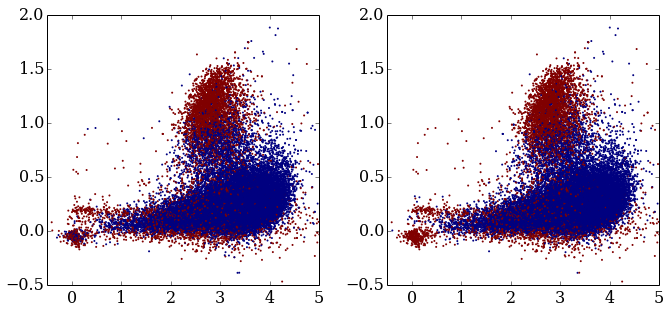

In [57]:
fig = plt.figure(figsize=(10, 5))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15, top=0.9, wspace=0.25)

# First axis shows the data
ax1 = fig.add_subplot(121)
im = ax1.scatter(X_test[:, 2], X_test[:, 3], c=y_test, s=4,
                 linewidths=0, edgecolors='none')
ax1.set_xlim([-0.5,5])
ax1.set_ylim([-0.5,2])
#im.set_clim(-0.5, 1)

ax2 = fig.add_subplot(122)
im = ax2.scatter(X_test[:, 2], X_test[:, 3], c=model.predict(X_test), s=4,
                 linewidths=0, edgecolors='none')
ax2.set_xlim([-0.5,5])
ax2.set_ylim([-0.5,2])

In [84]:
print "For GMM"
print "Galaxy precision recall"
print_prec_recall(0, model.predict(X_test), y_test)
print "Point source precision recall"
print_prec_recall(1, model.predict(X_test), y_test)

For GMM
Galaxy precision recall
For class 0 :    precision = 0.977693576972 ;   recall = 0.974804253115
Point source precision recall
For class 1 :    precision = 0.886307396206 ;   recall = 0.898286192002


In [71]:
model.gmms_[0].weights_

array([ 0.1034193 ,  0.21260442,  0.18361882,  0.19771369,  0.20004328,
        0.01461928,  0.0879812 ])

In [67]:
n_clusters = 7
n_iter = 1

#----------------------------------------------------------------------
# This is a long calculation: save results to file
#@pickle_results("XD_stellar.pkl")
def compute_XD(n_clusters=7, rseed=0, n_iter=n_iter, verbose=True, gmm_vars=None):
    if gmm_vars is None:
        print "no gmm_initialization variables passed"
    np.random.seed(rseed)
    clf = XDGMM(n_clusters, n_iter=n_iter, tol=1E-5, verbose=verbose)
    clf.fit(X, Xcov, gmm_vars=gmm_vars)
    return clf

clf = compute_XD(n_clusters, gmm_vars=gmm_vars)

In [ ]:
weights = np.array(gmm.weights_)
means = np.array(gmm.means_)
cov = np.array(gmm.covars_)
print weights
gmm_vars = (weights, means, cov)

xdeconv_testing.XDGMM

In [1]:
modelxd = gmm_bayes_xd.GMMBayesXD(n_components=7, n_init=1, random_state=10, min_covar=1.e-14, covariance_type='full')
modelxd.fit(X_train, y_train)

NameError: name 'gmm_bayes_xd' is not defined

In [3]:
reload(gmm_bayes_xd)

<module 'gmm_bayes_xd' from 'gmm_bayes_xd.pyc'>

In [5]:
from astroML.utils import split_samples

In [6]:
split_samples?